# Transfer learning в задаче "Road Damage Detection" с использованием ResNet18

### Классы поврежденний, присутствующие в тренировочном датасете
* D00: Продольная трещина (Longitudinal Crack)
* D10: Поперечная трещина (Transverse Crack)
* D20: Трещины типа "крокодиловая кожа" (Aligator Crack)
* D40: Выбоина / Яма (Pothole)

## 1. Импорт необходимых пакетов

In [1]:
import numpy as np
import os
import random
import time
import torch, torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from  matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

## 2. Фиксация сидов для воспроизводимости результатов

In [2]:
RANDOM_SEED = 46

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
print('В репозитории находятся следующие файлы:', os.listdir())

В репозитории находятся следующие файлы: ['.venv', '.idea', 'tl_rdd.ipynb', 'road_damage_dataset.py', 'requirements.txt', '__pycache__', 'plot_samples.py', 'LICENSE', '.gitignore', 'README.md', '.git', 'download_dataset.sh', 'Czech']


## 3. Подготовка датасетов

### Загружаем имеющиейся данные

In [4]:
from road_damage_dataset import RoadDamageDataset

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Полный тренировочный датасет
full_train_dataset = RoadDamageDataset(root_dir='Czech/train', transform=transform)


### Проверка распределения классов в тренировочных данных

In [21]:
train_stats = full_train_dataset.get_class_distribution()
total = sum(train_stats.values())

print("Распределение классов в тренировочных данных:")
for cls, count in train_stats.items():
    print(f"{cls}: {count} ({count/total:.1%})")

Распределение классов в тренировочных данных:
normal: 1757 (50.2%)
D00: 988 (28.2%)
D40: 197 (5.6%)
D10: 399 (11.4%)
D20: 161 (4.6%)


Выведем 5 произвольных изображений из тренировочного датасета

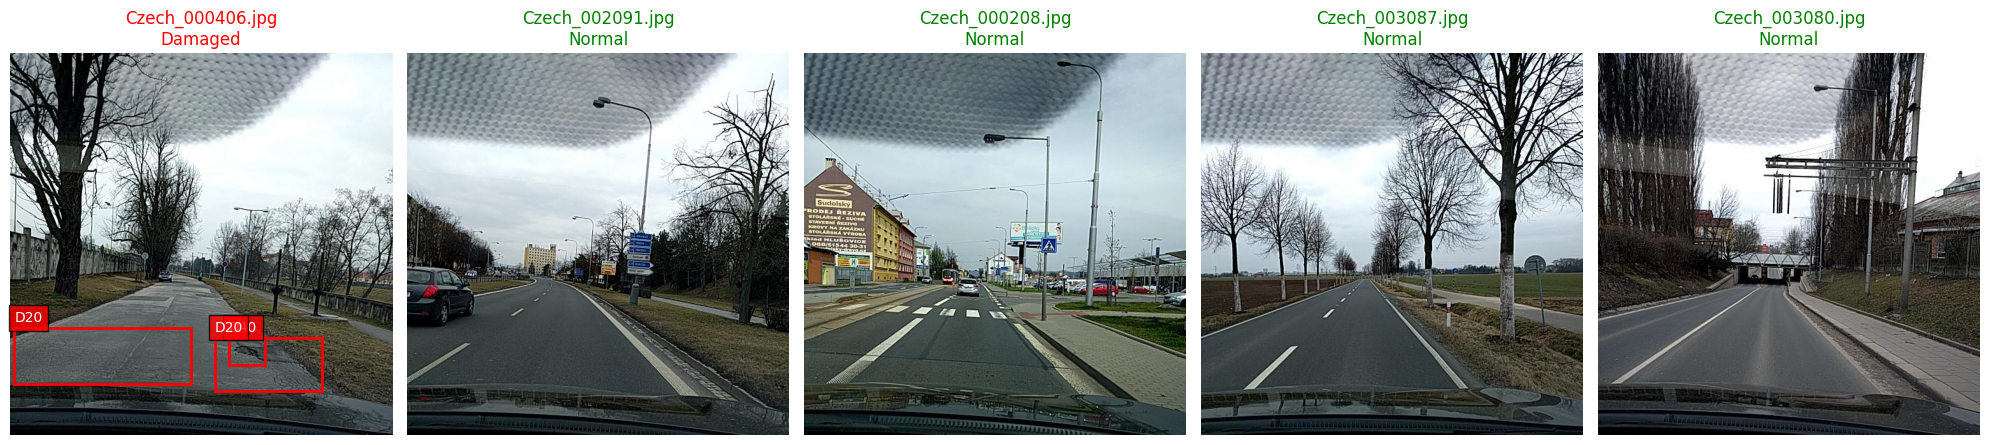

In [6]:
from plot_samples import plot_random_samples

plot_random_samples(full_train_dataset, full_train_dataset.class_name, 5)

### Из тренировочных данных выделяем набор для валидации обучения

In [7]:
# Модель ResNet18 ожидает на входе изображение 224х224х3
ResNet18_image_size = 224
target_size = (ResNet18_image_size, ResNet18_image_size)

# Константы среднего и стандартного распределения по каналам (из документации на модель)
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

# Ресайз и нормализация изображений для предобученной ResNet18
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(ResNet18_image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_nums, std=std_nums),
])

# Полный тренировочный датасет
full_train_dataset = RoadDamageDataset(root_dir='Czech/train', target_size=target_size, transform=transform)

# Выделяем из тренировочных данных данные для валидации (80/20)
train_idx, val_idx = train_test_split(
    range(len(full_train_dataset)),
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=[ann[0]['class'] for ann in full_train_dataset.annotations.values()]
)

# Делим на финальные подмножества тренировочных и валидационных
train_dataset = torch.utils.data.Subset(full_train_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_train_dataset, val_idx)

# Тестовый датасет (только изображения)
test_dataset = RoadDamageDataset(root_dir='Czech/test', target_size=target_size, transform=transform, is_test=True)


### Кол-во данных в каждом из полученных наборов

In [8]:
print(f"Количество тренировочных изображений: {len(train_dataset)}")
print(f"Количество валидационных изображений: {len(val_dataset)}")
print(f"Количество тестовых изображений: {len(test_dataset)}")

Количество тренировочных изображений: 2263
Количество валидационных изображений: 566
Количество тестовых изображений: 709


## 4. Создадим DataLoader'ы

Зададим вычислительное устройство:

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Используемое устройство: {device}")

Используемое устройство: cpu


Так как количество повреждений на изображении может варьироваться, используем функцию для упаковки данных в батчи:

In [10]:
def collate_fn(batch):
    """
    Обрабатывает батч вида [(image, objects), ...] где:
    - image: тензор [C, H, W]
    - objects: список словарей {'class': torch.tensor, 'bbox': torch.tensor}
    """
    # Разделяем изображения и объекты
    images, objects_list = zip(*batch)
    
    # Объединяем изображения в один тензор [B, C, H, W]
    images = torch.stack(images, dim=0)
    
    # Подготавливаем targets для Faster R-CNN
    targets = []
    for objects in objects_list:
        # Объединяем все объекты изображения
        bboxes = torch.stack([obj['bbox'] for obj in objects])
        classes = torch.stack([obj['class'] for obj in objects])
        
        target = {
            'bboxes': bboxes.float(),
            'classes': classes.long(),
        }

        targets.append(target)
    
    return images, targets

Загружаем данные

In [11]:
BATCH_SIZE = 5
NUM_WORKERS = 2

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
                              collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
                            collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

### Проверка загрузки одного батча

In [12]:
images, objects = next(iter(train_dataloader))

print(f"Размер батча изображений: {len(images)}")
print(f"Тип первого изображения: {type(images[0])}")
print(f"Размер первого изображения: {images[0].size() if isinstance(images[0], torch.Tensor) else images[0].size}")

print(f"\nПример аннотации для первого изображения: {objects[0]}")

print("\nПроверка скорости загрузки одного батча: ")
%timeit next(iter(train_dataloader))


Размер батча изображений: 5
Тип первого изображения: <class 'torch.Tensor'>
Размер первого изображения: torch.Size([3, 224, 224])

Пример аннотации для первого изображения: {'bboxes': tensor([[  0.,   0., 224., 224.]]), 'classes': tensor([0])}

Проверка скорости загрузки одного батча: 
168 ms ± 6.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Отобразим данные из батча

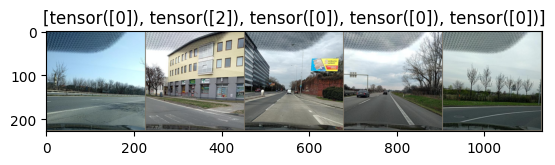

In [13]:
def imshow(inp, title=None):
    """Отображение изображения."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Make a grid from batch
out = torchvision.utils.make_grid(images)

imshow(out, title=[obj['classes'] for obj in objects])

## 5. Обучение модели ResNet18

In [25]:
NUM_CLASSES = 5

# Загрузка предобученной модели ResNet18
model = models.resnet18(weights='DEFAULT')
model = model.to(device)

# Замораживаем все слои, кроме последнего
for param in model.parameters():
    param.requires_grad = False

# Заменяем последний слой (5 классов: норма + 4 повреждения)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, NUM_CLASSES),
    nn.Sigmoid() 
)

# Только fc будет обучаться
optimizer = torch.optim.Adam([
    {'params': model.fc.parameters(), 'lr': 0.001},
    {'params': model.layer4.parameters(), 'lr': 0.0001}  # Частичная разморозка
], weight_decay=1e-4)

# Подсчет весов классов (примерные значения)
class_counts = torch.tensor([
    train_stats['normal'], train_stats['D00'],
    train_stats['D10'], train_stats['D20'],
    train_stats['D40']
])
class_weights = 1.0 / (class_counts / class_counts.min())  # Нормализация
class_weights = class_weights.to(device)

# Функция потерь
criterion = nn.BCEWithLogitsLoss(weight=class_weights)

Один этап обучения модели

In [ ]:
def train_epoch(model, loader, optimizer):
    # Перевод модели в режим обучения
    model.train()

    total_loss = 0.0
    total_samples = 0
    correct_predictions = torch.zeros(NUM_CLASSES).to(device)
    total_positives = torch.zeros(NUM_CLASSES).to(device)

    for images, targets in loader:
        images = images.to(device)
        # class_labels = [t['classes'].to(device) for t in targets]
        # bbox_labels = [t['bboxes'].to(device) for t in targets]
        
        class_labels = torch.zeros(len(targets), NUM_CLASSES, dtype=torch.float32).to(device)
        for i, item in enumerate(targets):
            class_indices = item['classes'].unique()  # Убираем дубликаты
            class_labels[i, class_indices] = 1.0  # Помечаем присутствующие классы

        # Обнуление параметров градиента
        optimizer.zero_grad()

        outputs = model(images)

        # Расчет потерь
        loss = criterion(outputs, class_labels)
        # for i in range(len(class_labels)):
        #     loss += nn.CrossEntropyLoss()(class_logits[i], class_labels[i])
        #     loss += nn.MSELoss()(bbox_preds[i], bbox_labels[i])

        loss.backward()
        optimizer.step()
        
        # Статистика
        total_loss += loss.item() * images.size(0)
        total_samples += images.size(0)
        
        # Расчет accuracy по классам
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_predictions += (preds == class_labels).sum(dim=0)
        total_positives += class_labels.sum(dim=0)
    
    # Микро-averaging accuracy
    accuracy = correct_predictions.sum() / total_samples / NUM_CLASSES
    return total_loss / total_samples, accuracy.item()


Валидация обучения

In [31]:
def validate(model, loader):
    # Перевод модели в режим работы
    model.eval()

    total_loss = 0.0
    total_samples = 0
    correct_predictions = torch.zeros(NUM_CLASSES).to(device)
    total_positives = torch.zeros(NUM_CLASSES).to(device)
    
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            # class_labels = [t['classes'].to(device) for t in targets]
            # bbox_labels = [t['bboxes'].to(device) for t in targets]
            class_labels = torch.zeros(len(targets), NUM_CLASSES, dtype=torch.float32).to(device)
            for i, item in enumerate(targets):
                class_indices = item['classes'].unique()  # Убираем дубликаты
                class_labels[i, class_indices] = 1.0  # Помечаем присутствующие классы

            outputs = model(images)
            loss = criterion(outputs, class_labels)
            
            total_loss += loss.item() * images.size(0)
            total_samples += images.size(0)
            
            preds = (torch.sigmoid(outputs) > 0.5).float()

            # print("Распределение предсказаний:")
            # print(preds.mean(dim=0))  # Среднее по каждому классу

            # print("Распределение истинных меток:")
            # print(class_labels.mean(dim=0))

            correct_predictions += (preds == class_labels).sum(dim=0)
            total_positives += class_labels.sum(dim=0)
    
    accuracy = correct_predictions.sum() / total_samples / NUM_CLASSES
    return total_loss / total_samples, accuracy.item()

Непосредственно цикл обучения

In [32]:
start_time = time.time()

for epoch in range(10):
    train_loss, train_acc = train_epoch(model, train_dataloader, optimizer)
    val_loss, val_acc = validate(model, val_dataloader)
    
    print(f'Эпоха {epoch+1}:')
    print(f'Обучение Loss: {train_loss:.4f} | Acc: {train_acc:.2%}')
    print(f'Валидация Loss: {val_loss:.4f} | Acc: {val_acc:.2%}\n')    

print('ОБщее время обучения {:.3f} секунд'.format(time.time() - start_time))

Эпоха 1:
Обучение Loss: 0.3433 | Acc: 21.83%
Валидация Loss: 0.3423 | Acc: 22.40%

Эпоха 2:
Обучение Loss: 0.3424 | Acc: 21.83%
Валидация Loss: 0.3423 | Acc: 22.40%

Эпоха 3:
Обучение Loss: 0.3423 | Acc: 21.83%
Валидация Loss: 0.3421 | Acc: 22.40%

Эпоха 4:
Обучение Loss: 0.3422 | Acc: 21.83%
Валидация Loss: 0.3420 | Acc: 22.40%

Эпоха 5:
Обучение Loss: 0.3422 | Acc: 21.83%
Валидация Loss: 0.3419 | Acc: 22.40%

Эпоха 6:
Обучение Loss: 0.3421 | Acc: 21.83%
Валидация Loss: 0.3418 | Acc: 22.40%

Эпоха 7:
Обучение Loss: 0.3421 | Acc: 21.83%
Валидация Loss: 0.3418 | Acc: 22.40%

Эпоха 8:
Обучение Loss: 0.3420 | Acc: 21.83%
Валидация Loss: 0.3418 | Acc: 22.40%

Эпоха 9:
Обучение Loss: 0.3420 | Acc: 21.83%
Валидация Loss: 0.3418 | Acc: 22.40%

Эпоха 10:
Обучение Loss: 0.3421 | Acc: 21.83%
Валидация Loss: 0.3417 | Acc: 22.40%

ОБщее время обучения 871.213 секунд


## 6.  Проверка предсказаний переобученной модели

Функция для предсказания с выводом результатов

In [ ]:
# Пороги для классов (подбираются при валидации)
thresholds = torch.tensor([0.5, 0.4, 0.6, 0.7, 0.6]).to(device)

def predict_and_show(model, dataset, idx, thresholds):
    """Предсказывает классы для изображения и выводит результат."""
    model.eval()
    image, annotation = dataset[idx]
    
    true_labels = torch.zeros(5)
    for obj in annotation:
        true_labels[obj['class'].unique()] = 1
    
    # Предсказание
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        probs = torch.sigmoid(output).cpu().numpy()[0]
        preds = (probs > np.array(thresholds, dtype=np.float32)).astype(np.int8)
    
    # Денормализация изображения для отображения
    image = image.cpu().numpy().transpose(1, 2, 0)
    image = image * np.array(std_nums) + np.array(mean_nums)
    image = np.clip(image, 0, 1)
    
    # Вывод результатов
    class_names = ['normal', 'D00', 'D10', 'D20', 'D40']
    print("\nРезультаты предсказания:")
    print(f"{'Класс':<10} {'Истина':<8} {'Предсказание':<12} {'Вероятность':<10}")
    for i, name in enumerate(class_names):
        print(f"{name:<10} {true_labels[i]:<8} {preds[i]:<12} {probs[i]:<10.4f}")
    
    # Визуализация
    plt.figure(figsize=(10, 5))
    plt.imshow(image)
    plt.title(f"Предсказание (ID: {idx})")
    plt.axis('off')
    plt.show()


Результаты предсказания:
Класс      Истина   Предсказание Вероятность
normal     1.0      1            0.5573    
D00        0.0      1            0.5001    
D10        0.0      0            0.5000    
D20        0.0      0            0.5000    
D40        0.0      0            0.5000    


/tmp/ipykernel_3621098/1845697134.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  preds = (probs > np.array(thresholds, dtype=np.float32)).astype(np.int8)


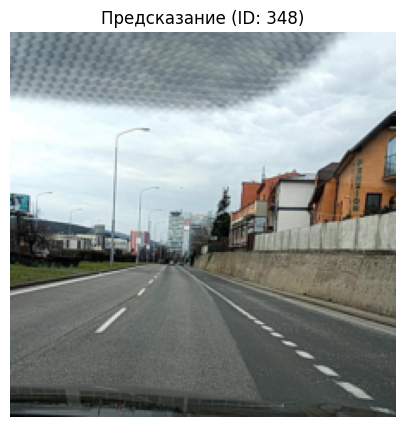


Результаты предсказания:
Класс      Истина   Предсказание Вероятность
normal     1.0      1            0.6903    
D00        0.0      1            0.5001    
D10        0.0      0            0.5000    
D20        0.0      0            0.5000    
D40        0.0      0            0.5000    


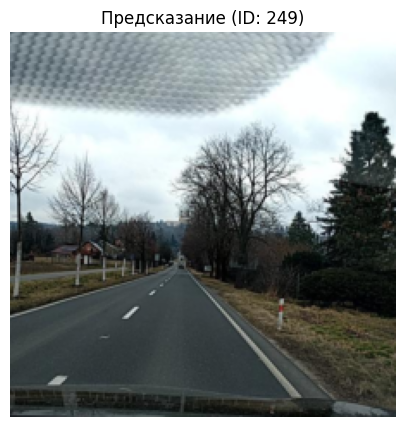


Результаты предсказания:
Класс      Истина   Предсказание Вероятность
normal     0.0      1            0.7152    
D00        1.0      1            0.5000    
D10        0.0      0            0.5000    
D20        0.0      0            0.5000    
D40        0.0      0            0.5000    


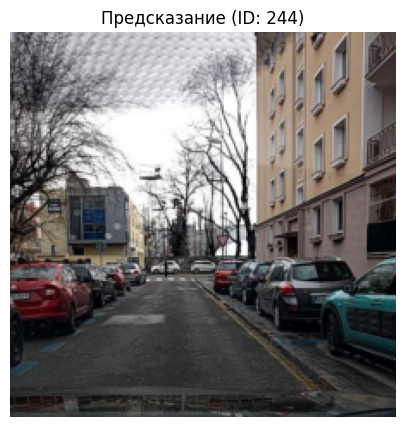

In [38]:
# Выберем 3 случайных изображения для проверки
indices = torch.randint(0, len(val_dataset), (3,))

for idx in indices:
    predict_and_show(model, val_dataset, idx.item(), thresholds)